In [1]:
%matplotlib inline
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

<h3>1. Load the historical data</h3>
<br>
<blockquote>
    <ul>
        <li>Period: 01-01-2020 to 31-12-2020</li>
        <li>Frequence: daily prices</li>
        <li>Source: Yahoo Finance</li>
        <li>Risk factors: SPY, TLT, GLD and S&P 500 (Benchmark)</li>
    </ul>
</blockquote>

In [2]:
ROOT_PATH = os.getcwd()

factor_names = ["SPY", "TLT", "GLD", "SP500"]
file_paths = [os.path.join(ROOT_PATH, "input", "2020", f) + ".csv" for f in factor_names]
file_paths = list(zip(factor_names, file_paths))

cols = ["Date", "Adj Close"]

factor_dfs = []
for f in file_paths:
    _df = pd.read_csv(f[1], infer_datetime_format=True, index_col="Date", usecols=cols)
    _df.rename(columns={"Adj Close": f[0]}, inplace=True)
    factor_dfs.append(_df)
    
# Master Factor Prices (MFP)
mfp = pd.concat(factor_dfs, axis=1, ignore_index=False)
mfp.head()

,SPY,TLT,GLD,SP500
Date,,,,
2020-01-02,318.914307,135.004837,143.949997,3257.850098
2020-01-03,316.499451,137.083969,145.860001,3234.850098
2020-01-06,317.706909,136.305542,147.389999,3246.280029
2020-01-07,316.813568,135.635468,147.970001,3237.179932
2020-01-08,318.502075,134.738815,146.860001,3253.050049


<h3>2. Returns</h3>
<br>
<blockquote>
    General notes:
    <ul>
        <li>The portfolio return at a specific time $i=t$ can be computed as $\sum_{j=1}^{N}{w_{t_j} r_{t_j}}$ where $r_{t_j}$ is a simple (not log) return defined as $\frac{p_{t_j}}{p_{t-1_j}}-1$. <br>$N$ is the number of holdings in the portfolio, $T$ the number of periods and $w_{t_j}$ the weight of security $j$ at time $t$.</li>
        <li>Log returns are additive overtime, $r_{t_j}=log(\frac{p_{t_j}}{p_{t-1_j}})=log(p_{t_j})-log(p_{t-1_j})$. <br>We can then for example compute the cumulative return of a security $j$ with $\prod_{i=t}^{T} (1+r_{i_j})-1$.</li>
        <li>Arithmetic mean provides an unbiased estimate of the return for the following period $\frac{1}{T}\sum_{i=t}^{T} r_{i_j}$.</li>
        <li>Geometric mean is a good measure of the historical performance since it accounts for the compounding effect of returns $(\prod_{i=t}^{T} (1+r_{i_j}))^{\frac{1}{T}} -1$.</li>
    </ul>
</blockquote>

In [3]:
# Master Factor Returns (MFR): Daily change percent
mfr = mfp.copy()
mfr = mfr.pct_change()\
         .dropna()

mfr.head()

,SPY,TLT,GLD,SP500
Date,,,,
2020-01-03,-0.007572,0.015400,0.013269,-0.007060
2020-01-06,0.003815,-0.005678,0.010489,0.003533
2020-01-07,-0.002812,-0.004916,0.003935,-0.002803
2020-01-08,0.005330,-0.006611,-0.007502,0.004902
2020-01-09,0.006781,0.003510,-0.005652,0.006655


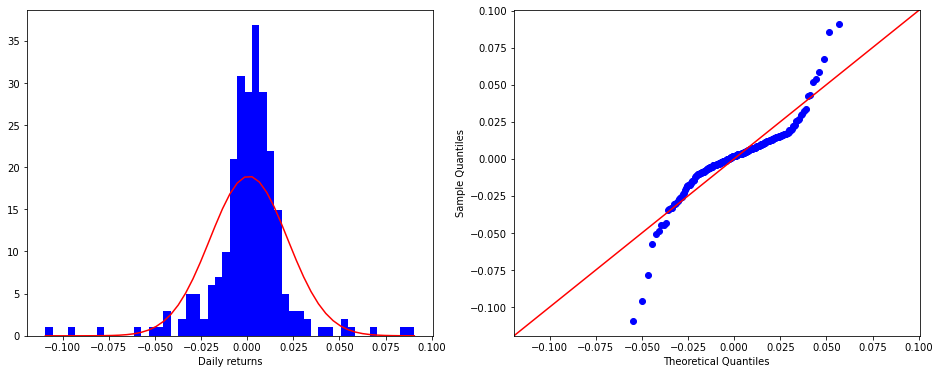

In [4]:
# Intermediary quick visual check
# The Normal distribution is a good and simple approximation of stocks returns.
# However the difference is found in the skewness, heavy tails and volatility clustering
fig, ax = plt.subplots(1, 2, figsize=(16,6))

n, bins, patches = ax[0].hist(mfr['SPY'], bins=50, density=True, color="b")
ax[0].set_xlabel("Daily returns")

sigma = np.std(mfr['SPY'])
mu = np.mean(mfr['SPY'])
ax[0].plot(bins, stats.norm.pdf(bins, mu, sigma), 'r')

# Q-Q plot of the residuals against quantiles of normal-distribution
sm.qqplot(mfr['SPY'], fit=False, line="45", loc=mu, scale=sigma, ax=ax[1])

plt.show()

In [5]:
# Computing the portfolio returns with weights SPY:0.5, GLD:0.4, TLT:0.1
# Portfolio Returns (rp)
port_factors = ['SPY', 'TLT', 'GLD']
port_weights = np.array([0.5, 0.4, 0.1]).reshape(-1,1)
mfr["rp"] = mfr[port_factors].dot(port_weights)
mfr = mfr.round(4)
mfr.head()

,SPY,TLT,GLD,SP500,rp
Date,,,,,
2020-01-03,-0.0076,0.0154,0.0133,-0.0071,0.0037
2020-01-06,0.0038,-0.0057,0.0105,0.0035,0.0007
2020-01-07,-0.0028,-0.0049,0.0039,-0.0028,-0.0030
2020-01-08,0.0053,-0.0066,-0.0075,0.0049,-0.0007
2020-01-09,0.0068,0.0035,-0.0057,0.0067,0.0042


<h3>3. Technical information</h3>

<h6>Tracking Error</h6>
<blockquote>
    Measures the dispersion of the relative performance of a portfolio to its benchmark.<br>
    $TE=\sigma(r_p - r_b)$ where $r_p$ is the portfolio returns and $r_b$ the benchmark returns
    

In [6]:
TE = round(np.std(mfr["rp"] - mfr["SP500"])* 100, 2)
print("Tracking Error = {}%".format(TE))

Tracking Error = 1.46%


<h6>Correlation</h6>
<blockquote>
    Measures the linear dependence between two risk factors (securities).<br>
    $\rho(x_1, x_2)=\frac{\sum(x_1, x_2)}{\sigma(x_1)\sigma(x_2)}$ where $x_1, x_2$ are risk factors and $\sum(x_1, x_2)$ is the covariance matrix between $x_1$ and $x_2$.
    

In [7]:
CORRpb = mfr['rp'].corr(mfr['SP500'])
print("Correlation = {}%".format(round(CORRpb * 100, 2)))

Correlation = 83.48%


<h6>Volatility</h6>
<blockquote>
    Risk measure quantifying securities return dispersion around it's mean.<br>
    <ul>
        <li>Single security $j$: $\sigma(r_j)$</li>
    <li>Portfolio $p$: $\sqrt{w^{T}_p\sum_p w_p}$ where $w^{T}_p$ it the transposed of the portfolio weight vector and $\sum_p$ the covariance matrix of the portfolio.</li>
    </ul>

In [8]:
port_covariance = mfr[port_factors].cov()
port_variance = port_weights.T * np.matrix(port_covariance) * port_weights
port_volatility = np.sqrt(port_variance)
print("Volatility = {}%".format(round(port_volatility.item(0) * 100, 2)))

Volatility = 0.97%


<h6>Beta</h6>
<blockquote>
    Measures the sensitivity of a security to another risk factor, e.g. the market.
    <ul>
    <li>$\beta_j=\frac{\sum(r_j, r_b)}{\sigma(r_b)}$ where $r_j$ is the return vector of security $j$ and $\sigma(r_b)$ is the standard deviation of the benchmark returns.</li>
    <li>The $\beta$ can also be obtained by running a linear regression on the following equation: $E[r_j]=r_f+\beta_j(E[r_b]-r_f)$, where $r_f$ is the risk-free rate.</li>
    </ul>
    

In [9]:
VARb = np.var(mfr["SP500"])
COVpb = mfr['rp'].cov(mfr['SP500'])
BETA = COVpb/VARb
print("BETA = {}".format(round(BETA, 2)))

BETA = 0.37
